# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [301]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

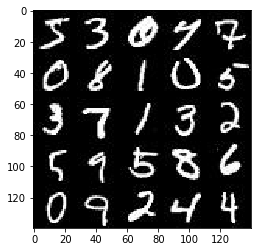

In [302]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

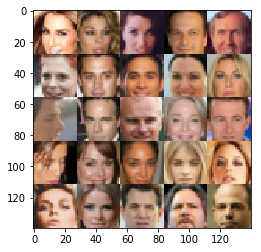

In [303]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [304]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/congcong/anaconda/envs/tensorflow1.0/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


# Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

In [305]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

## About conv2d output shape
Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

When you're apply padding = 'same' then the image dimension (height and width) is only influenced by strides but not by kernal size.

When you're apply padding = 'valid' then the image dimension (height and width) is only influenced by strides and by kernal size.

So that's what is happening with your case.

X2 has a shape of 6,6,256 ---- which is then applied into the tf.layers.conv2d_transpose with stride of 2 to get the X3 with the shape of 12,12,128 (6x2,6x2,depth)

Lets look at the below equations when applying conv2d_layer not conv2d_transpose layer.
If Padding = "VALID" the output height and width are computed as:

new_height = ((input_height - filter_height + 2 * P)/S) + 1
new_width = ((input_width - filter_width + 2 * P)/S) + 1

https://classroom.udacity.com/nanodegrees/nd101/parts/f6d74d04-6d65-424a-9f3a-d58f4da7d406/modules/ca299d5f-35f6-4520-a2b0-74c6878008b3/lessons/2fd24529-215c-47b5-a644-2c23650493f6/concepts/4f028128-6c6a-41e1-80cd-58f54189615d23

If Padding = 'SAME', the output height and width are computed as:
out_height = ceil(float(in_height) / float(strides[1]))
out_width = ceil(float(in_width) / float(strides[2]))

So in conv2d_transpose layer with padding = 'same', image dimensions are multiplied by strides instead of divide.

In [326]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        
        # 14x14x64
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 7x7x128
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        # 4x4x256
        
        # flatten into 1
        flat = tf.reshape(x2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [325]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # TODO: Implement Function
    alpha = 0.2

    with tf.variable_scope('generator', reuse=not is_train):
        #################################
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        #################################
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=not is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # 7x7x512
        x2 = tf.layers.conv2d_transpose(x1, 128, 2, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=not is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 14x14x256
        
        # output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        
        # 28x28x3
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [327]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    input_fake = generator(input_z, out_channel_dim, is_train=True)
    
    output_real, logits_real = discriminator(input_real, reuse=False)
    output_fake, logits_fake = discriminator(input_fake, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=tf.ones_like(output_real)))
    
    d_loss_fake = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.zeros_like(output_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.ones_like(output_fake)))
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [309]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainable_variables = tf.trainable_variables()
    
    discriminator_vars = [var for var in trainable_variables if var.name.startswith('discriminator')]
    generator_vars = [var for var in trainable_variables if var.name.startswith('generator')]
    
    # Optimizer
    ################################################################################
#     with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    ################################################################################
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_vars)
    
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [310]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1] # get tensor shape
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [333]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
#     saver = tf.train.Saver()
    print(learning_rate)
    iteration = 1
    
    # Get inputs
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    print(lr)
    # Loss
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    # Optimizer
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
#         sess.run(tf.reset_default_graph())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run Opt
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z, 
                                                     lr: learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, 
                                                     input_real: batch_images, 
                                                     lr: learning_rate})
                
                # show Loss
                if iteration % 30 == 0:
                    train_loss_d = sess.run(d_loss, feed_dict={input_real: batch_images, 
                                                               input_z: batch_z})
                    train_loss_g = sess.run(g_loss, feed_dict={input_z: batch_z})
                    
                    print("Epochs: {}/{}".format(epoch_i, epoch_count), 
                         "Discriminator Loss: {:.4f}...".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                if iteration % 100 == 0:
                    show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)
                        
                iteration += 1
#         saver.save(sess, './checkpoints/face_generator.ckpt')

In [334]:
101%100

1

# MNIST
Test your GANs architecture on MNIST. After 2 epochs, the GANs should be able to generate images that look like handwritten digits. Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [335]:
print("MNIST Data Size: {}".format(mnist_dataset.shape))

MNIST Data Size: (60000, 28, 28, 1)


0.0002
Tensor("learning_rate:0", dtype=float32)
Epochs: 0/2 Discriminator Loss: 0.2897... Generator Loss: 1.4259
Epochs: 0/2 Discriminator Loss: 0.0389... Generator Loss: 5.1891
Epochs: 0/2 Discriminator Loss: 0.2167... Generator Loss: 2.2749


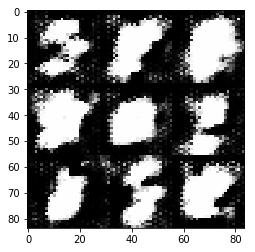

Epochs: 0/2 Discriminator Loss: 1.7422... Generator Loss: 0.3042
Epochs: 0/2 Discriminator Loss: 0.2533... Generator Loss: 3.7705
Epochs: 0/2 Discriminator Loss: 0.2046... Generator Loss: 2.3369


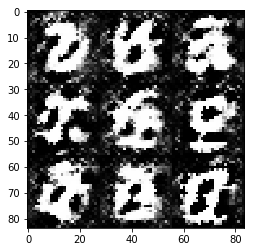

Epochs: 0/2 Discriminator Loss: 0.4029... Generator Loss: 1.5778
Epochs: 0/2 Discriminator Loss: 0.3855... Generator Loss: 2.4286
Epochs: 0/2 Discriminator Loss: 0.3148... Generator Loss: 1.9179
Epochs: 0/2 Discriminator Loss: 0.4734... Generator Loss: 2.1113


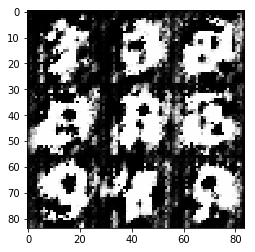

Epochs: 0/2 Discriminator Loss: 0.2179... Generator Loss: 2.3246
Epochs: 0/2 Discriminator Loss: 0.2018... Generator Loss: 2.1823
Epochs: 0/2 Discriminator Loss: 0.0799... Generator Loss: 4.0273


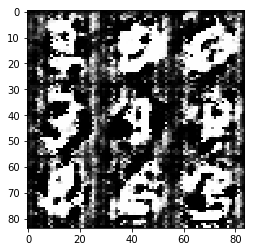

Epochs: 0/2 Discriminator Loss: 0.1629... Generator Loss: 2.4942
Epochs: 0/2 Discriminator Loss: 0.1864... Generator Loss: 2.1136
Epochs: 0/2 Discriminator Loss: 0.1333... Generator Loss: 2.8292


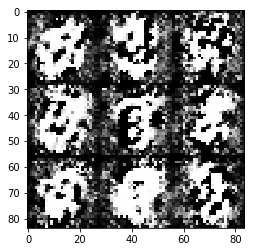

Epochs: 0/2 Discriminator Loss: 0.1078... Generator Loss: 2.8194
Epochs: 0/2 Discriminator Loss: 0.1357... Generator Loss: 2.6822
Epochs: 0/2 Discriminator Loss: 0.1731... Generator Loss: 2.2327
Epochs: 0/2 Discriminator Loss: 0.2916... Generator Loss: 1.7242


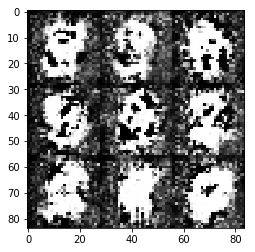

Epochs: 0/2 Discriminator Loss: 0.3153... Generator Loss: 1.8033
Epochs: 0/2 Discriminator Loss: 0.2785... Generator Loss: 1.8142
Epochs: 0/2 Discriminator Loss: 0.2332... Generator Loss: 2.0567


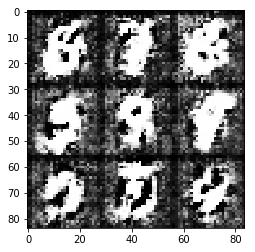

Epochs: 0/2 Discriminator Loss: 0.2742... Generator Loss: 1.7125
Epochs: 0/2 Discriminator Loss: 0.2613... Generator Loss: 2.2891
Epochs: 0/2 Discriminator Loss: 0.2035... Generator Loss: 2.0881


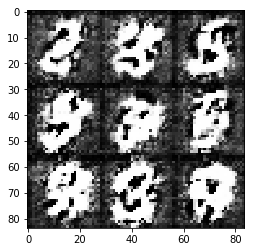

Epochs: 0/2 Discriminator Loss: 0.3119... Generator Loss: 1.5028
Epochs: 0/2 Discriminator Loss: 0.1196... Generator Loss: 3.1205
Epochs: 0/2 Discriminator Loss: 0.1421... Generator Loss: 2.7991
Epochs: 0/2 Discriminator Loss: 0.2028... Generator Loss: 4.2759


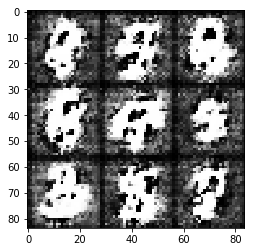

Epochs: 0/2 Discriminator Loss: 0.1294... Generator Loss: 3.2479
Epochs: 0/2 Discriminator Loss: 0.1502... Generator Loss: 3.5142
Epochs: 0/2 Discriminator Loss: 0.9922... Generator Loss: 0.5723


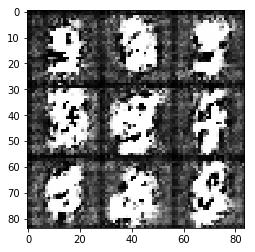

Epochs: 0/2 Discriminator Loss: 0.1026... Generator Loss: 3.2392
Epochs: 0/2 Discriminator Loss: 0.0948... Generator Loss: 3.3059
Epochs: 0/2 Discriminator Loss: 0.1072... Generator Loss: 2.7150


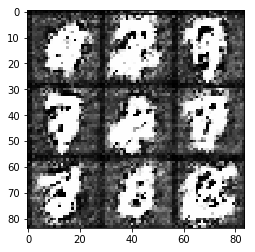

Epochs: 0/2 Discriminator Loss: 0.0796... Generator Loss: 3.5491
Epochs: 0/2 Discriminator Loss: 0.1182... Generator Loss: 2.7265
Epochs: 0/2 Discriminator Loss: 0.1147... Generator Loss: 2.6647
Epochs: 0/2 Discriminator Loss: 0.0667... Generator Loss: 3.1985


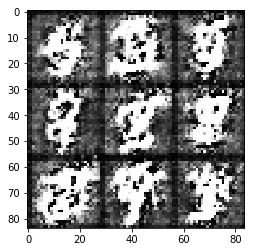

Epochs: 1/2 Discriminator Loss: 0.0698... Generator Loss: 3.2670
Epochs: 1/2 Discriminator Loss: 0.0695... Generator Loss: 3.6817
Epochs: 1/2 Discriminator Loss: 0.0689... Generator Loss: 3.4511


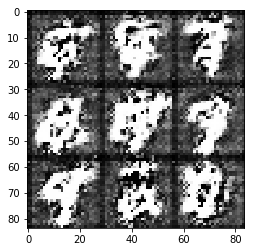

Epochs: 1/2 Discriminator Loss: 0.0988... Generator Loss: 4.0874
Epochs: 1/2 Discriminator Loss: 0.0400... Generator Loss: 4.1014
Epochs: 1/2 Discriminator Loss: 0.0482... Generator Loss: 4.1211


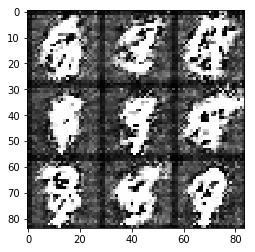

Epochs: 1/2 Discriminator Loss: 0.0472... Generator Loss: 3.9111
Epochs: 1/2 Discriminator Loss: 0.0597... Generator Loss: 3.8393
Epochs: 1/2 Discriminator Loss: 0.0231... Generator Loss: 4.5202
Epochs: 1/2 Discriminator Loss: 0.0437... Generator Loss: 4.0448


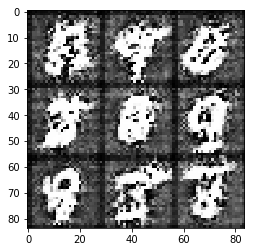

Epochs: 1/2 Discriminator Loss: 0.4208... Generator Loss: 2.3236
Epochs: 1/2 Discriminator Loss: 0.0879... Generator Loss: 3.2670
Epochs: 1/2 Discriminator Loss: 0.0542... Generator Loss: 3.7508


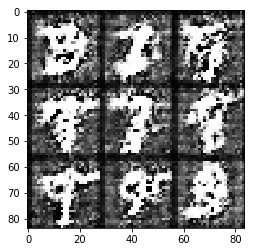

Epochs: 1/2 Discriminator Loss: 0.0621... Generator Loss: 3.9224
Epochs: 1/2 Discriminator Loss: 0.0469... Generator Loss: 3.7776
Epochs: 1/2 Discriminator Loss: 0.0632... Generator Loss: 3.6631


KeyboardInterrupt: 

In [336]:
batch_size = 50
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.